# Example: North-to-south strip of Spiekeroog 
## Implementation of the phase-averaged tidal boundary condition (PA-TBC) in SEAWAT using flopy

Here, the implementation of the phase-averaged tidal boundary condition (PA-TBC) presented in **Haehnel et al. (202X)** is showcased for a small strip of the island of Spiekeroog, Northern Germany.

For runtime reasons only a cross-section is implemented.
This script showcases how to implement the PA-TBC when the aquifer-ocean boundary is not located at uppermost model layer.

Input data is in 'data/'
* allow_tbc.tif, model cells allowed to hold a PA-TBC
* spk_part_dem.tif, digital elevation model for the model area (Sievers et al. 2020)
* tide_WW_avg30mins_2012-11-01_to2014-11-30.txt, 30-min averaged sea level data of tide gauge Wangerooge West (WSV, 2021)
* tide_WW_phaseavg_2012-11-01_to2014-11-30.txt, high and low water, mean tide level (based on WSV, 2021)

Model input and output files are saved in folder 'mf2005_spk_part_pa-tbc' (~1.8 GB).
QGIS file 'define_tbc_allow_area.qgz' is for definition of the areas allowed to hold the PA-TBC (below 4 m asl and not within the dune area of the island).

### References
**Haehnel et al. (202X)**

Mulligan, A. E., Langevin, C., & Post, V. E. A. (2011). Tidal Boundary Conditions in SEAWAT. Ground Water, 49(6), 866–879. https://doi.org/10.1111/j.1745-6584.2010.00788.x

Röper, T., Kröger, K. F., Meyer, H., Sültenfuss, J., Greskowiak, J., & Massmann, G. (2012). Groundwater ages, recharge conditions and hydrochemical evolution of a barrier island freshwater lens (Spiekeroog, Northern Germany). Journal of Hydrology, 454–455, 173–186. https://doi.org/10.1016/j.jhydrol.2012.06.011

Sievers, J., Rubel, M., & Milbrandt, P. (2020). EasyGSH-DB: Bathymetrie (1996-2016) [Data set]. Bundesanstalt für Wasserbau (BAW) [Federal Waterways Engineering and Research Institute]. https://doi.org/10.48437/02.2020.K2.7000.0002

Wasserstraßen- und Schifffahrtsverwaltung des Bundes (WSV) [Federal Waterways and Shipping Administration]. (2021). Sea level time series data for tide gauge Wangerooge West from 1999 to 2021 (1 min) [Data set]. Provided by Bundesanstalt für Gewässerkunde (BfG) [German Federal Institute of Hydrology].

### License
The digital elevation model data is from the EasyGSH-DB project (https://mdi-de.baw.de/easygsh/)
The data is licensed under a
Creative Commons Attribution 4.0 International License
(CC BY 4.0)
https://creativecommons.org/licenses/by/4.0/

License information is provided under
https://mdi-de.baw.de/easygsh/EasyEN_Imp_Daten.html#home
and https://datenrepository.baw.de/trefferanzeige?cmd=doShowDocument&docuuid=590135db-1776-450d-9fe3-ac6484cf64aa&plugid=/ingrid-group:iplug-ige-datenrepo


The tide data obtained from the WSV is licensed under a
Creative Commons Attribution 4.0 International License
(CC BY 4.0)
https://creativecommons.org/licenses/by/4.0/

License information is provided under
https://www.govdata.de/web/guest/suchen/-/details/pegelonline (German language only)

The tide data included here is processed from the original 1-min time series received from the WSV.


In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import datetime
import flopy
import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colors
from matplotlib import cm
from matplotlib import patches
from matplotlib import lines

path_patbc = os.path.abspath('../../')
sys.path.append(path_patbc)
import mfpatbc

In [2]:
#plt.switch_backend('nbAgg')
%matplotlib inline

### Tide gauge data

Sea level data is from tide gauge Wangerooge West. Measurement intervall is 1 min. This data was kernel smoothed. Data was averaged to 30 minute intervalls. High water (HW) and low water (LW) data was obtained from the kernel smoothed 1 minute increment time series. Mean tide level
$$\mathrm{MTL} = \frac{\mathrm{HW}+\mathrm{LW}}{2}$$

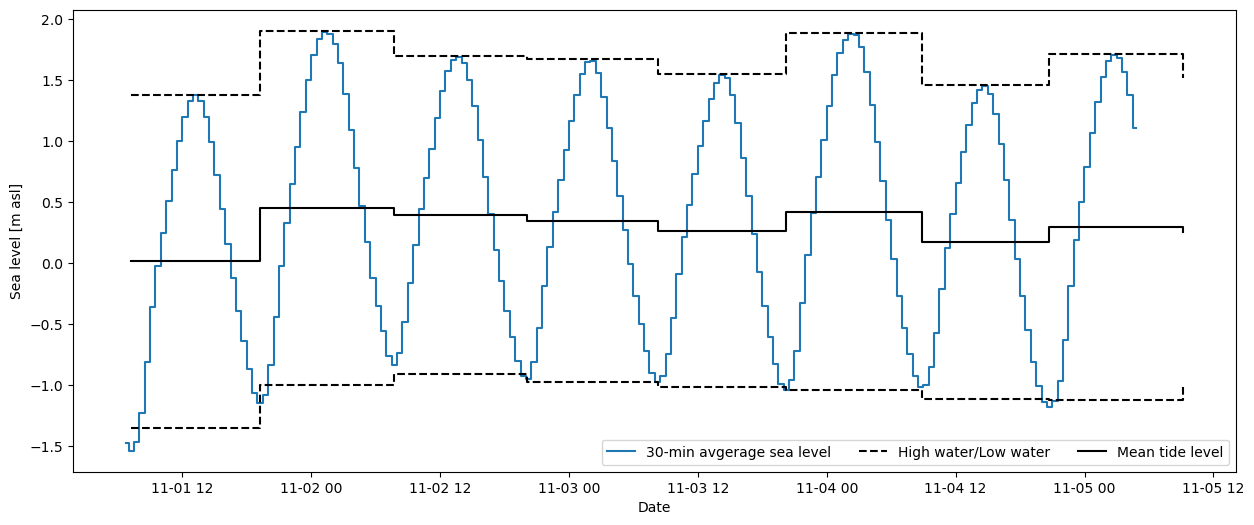

In [3]:
# Import tide gauge data -----
# Define time period
start_time = datetime.datetime(2012, 11, 1, 1, 00, 00)
#start_time = datetime.datetime(2013, 1, 15, 1, 00, 00)
end_time = datetime.datetime(2014, 11, 30, 23, 59, 59)
#end_time = datetime.datetime(2013, 2, 5, 23, 59, 59)

# 30-min averaged sea level data
tide = pd.read_csv('data/tide_WW_avg30mins_2012-11-01_to_2014-11-30.txt',
                  parse_dates = ['DateTime_Start', 'DateTime_Mean', 'DateTime_End'])
tide = tide.loc[(tide.DateTime_Start >= start_time) & \
                (tide.DateTime_End <= end_time), ]

# Phase-averaged data, High and low water information
hwlw = pd.read_csv('data/tide_WW_phaseavg_2012-11-01_to_2014-11-30.txt',
                  parse_dates = ['DateTime_Start', 'DateTime_Mean', 'DateTime_End'])
mhw = hwlw.HW.mean()
mlw = hwlw.LW.mean()
hwlw = hwlw.loc[(hwlw.DateTime_Start >= start_time) & \
                (hwlw.DateTime_End <= end_time), ]


# Visualize -----
fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.step(tide.DateTime_Mean.values[11:200], tide.WaterLevelNHN_Mean.values[11:200], where = 'mid',
       label = '30-min avgerage sea level')
ax.step(hwlw.DateTime_Start.values[0:9], hwlw.HW.values[0:9], where = 'post', linestyle = '--', color = 'k',
       label = 'High water/Low water')
ax.step(hwlw.DateTime_Start.values[0:9], hwlw.LW_Mean.values[0:9], where = 'post', linestyle = '--', color = 'k')
ax.step(hwlw.DateTime_Start.values[0:9], hwlw.SL_HWLW.values[0:9], where = 'post', linestyle = '-', color = 'k',
       label = 'Mean tide level')

ax.set_xlabel('Date')
ax.set_ylabel('Sea level [m asl]')

ax.legend(ncol = 3)

### Digital elevation model

Surface elevation data is required as input data for the PA-TBC and to define beach slopes for the PA-TBC. Figure below shows surface elevations and some locations (points) where simulation results are plotted for further below. The cross-section simulated with SEAWAT crosses these points.

[ 20  40  60  80 100 120 140]


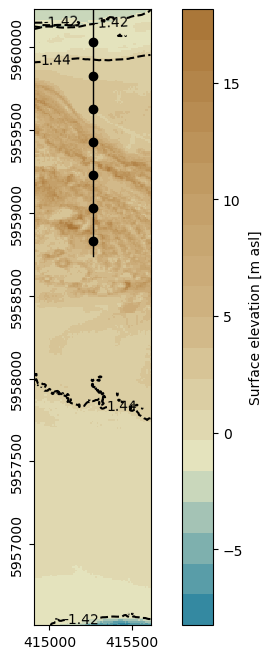

In [4]:
# Import surface elevation data -----
rst=rasterio.open('data/spk_part_dem.tif') ### topography on 10m x 10m grid
top=np.copy(rst.read()[0]) # get topography

# Discretization information
dx = dy = rst.get_transform()[1]
xul, yul = rst.get_transform()[0], rst.get_transform()[3]
nrow = top.shape[0] # number of model rows
ncol = top.shape[1] # number of model columns

# Cell center locations
x = xul + np.arange(0, dx*ncol, dx) + 0.5*dx
y = (yul - np.arange(0, dy*nrow, dy) - 0.5*dy)
X, Y = np.meshgrid(x, y)

# Locations where simulation results are plotted
col_plt = int(ncol/2)

use_cols = [col_plt]
use_rows = np.arange(0, 150)
top_cs = top[use_rows, use_cols].reshape(-1, 1)
nrow = len(use_rows)
ncol = 1#top_cs.shape[1]
y_use = y[use_rows]

row_plt = np.linspace(20, nrow-10, 7).astype(int)
print(row_plt)

# Visualize topography -----
# Topography colorbar
clrs_topo = np.array([(52, 138, 162), (230, 230, 193),
                      (209, 181, 131), (192, 153, 97), (171, 119, 57)])/256
cmap_topo = colors.LinearSegmentedColormap.from_list('cmap_topo', clrs_topo, N = 20)

# Plot
fig, ax = plt.subplots(1, figsize=(8, 8))
im = ax.pcolormesh(X, Y, top, shading = 'nearest', cmap = cmap_topo)
cbar = fig.colorbar(im, ax = ax)
cbar.set_label('Surface elevation [m asl]')

ct = ax.contour(X, Y, top, levels = [mlw, mhw], colors = 'k', linestyles = '--')
ax.clabel(ct, fmt = '%.2f', inline_spacing = 50)

ax.plot(x[col_plt].repeat(y_use.size), y_use, 'k', linewidth = 1)
ax.plot(x[col_plt].repeat(row_plt.size), y[row_plt], 'ko')

yt = ax.get_yticks()[1:-1:]
ax.set_yticks(yt)
ax.set_yticklabels([int(ytl) for ytl in yt], rotation = 90, verticalalignment = 'center')

ax.set_aspect('equal')

### Flow model

Regular grid with vertical discretization of 0.5 m is used. Cells with cell bottom elevations above surface elevation are deactivated and their upper boundary is adjusted to match the surface elevation at this location. Thus, cell in the first active layer at a certain row and column may be thinner than 0.5 m.

As outlined in Mulligan et al. (2011), simulations are not numerically stable when using the LPF package with cells wetting and drying repeadetly. Thus, BCF was used and cell wetting was only allowed from cells below. 

Recharge is set to 350 mm/yr, a value realistic for Spiekeroog (Röper et al., 2012).

Initially, a 10-year stress period with average tidal forcing is applied to obtain a quasi steady-state salt distribution in the aquifer.

In [5]:
# Vertical discretization ----

topval = np.repeat(12.5, nrow*ncol).reshape(nrow, ncol)
bottom = -40 # Change to -3 to test attribute active of mfpatbc.PATBC()
dz = 0.5
nlay = int((topval[0, 0] - bottom) / dz) 
print(f'Number of model layers: {nlay}')
botm = np.repeat(np.arange(topval[0, 0] - dz, bottom - dz, -dz), nrow*ncol).reshape((nlay, nrow, ncol))

Number of model layers: 105


In [6]:
# Create SEAWAT model object -----
path = '.'
swtv4_exe = os.path.abspath('../../bin/swtv4')
modelname = 'swtv4_spk_part'
model_ws = os.path.join(path, modelname)
swt = flopy.seawat.Seawat(modelname = modelname, exe_name = swtv4_exe, model_ws = model_ws)

# Define parameters ----
hk = 2e-4 * 86400 # m/day
sy = 0.3
vka = 1
vk = hk/vka
z_D = np.unique(botm[-1].copy())[0]

ss = 1e-5

Text(0, 0.5, 'Elevation [m asl]')

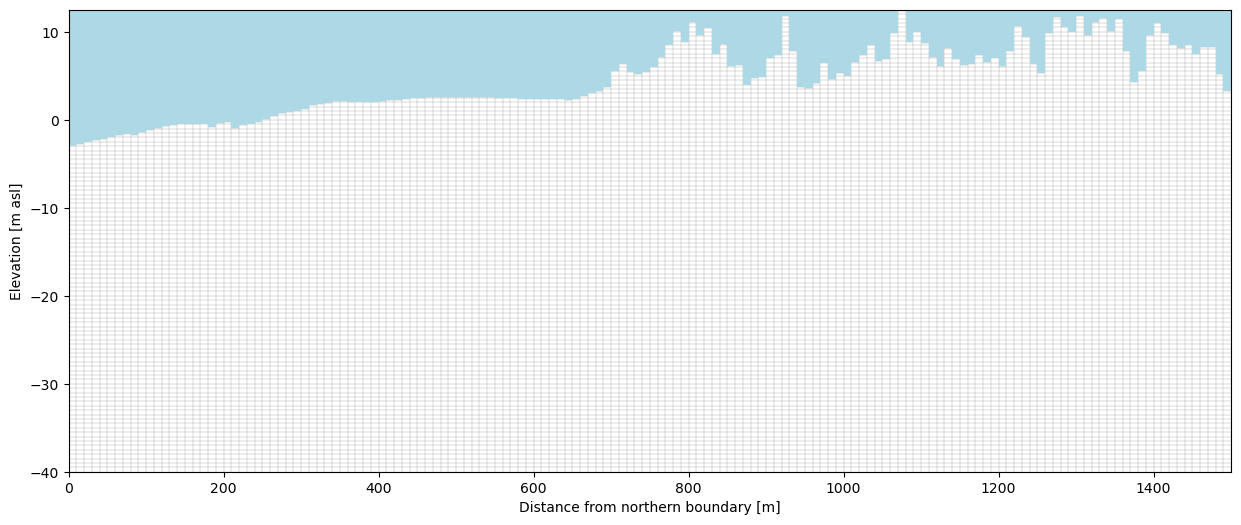

In [7]:
# Create objects for MODFLOW packages -----

# Define active cells
ibound = np.full((nlay,nrow,ncol), True)
ibound[0] = botm[0] < top_cs
topval[ibound[0]] = top_cs[ibound[0]]
for k in range(0, nlay):
    ibound[k, ::, ::] = botm[k] < top_cs
    # Find cells in layer that represent ground surface and set their upper boundary according to the DEM
    is_top = (ibound[k-1, ::, ::] == False) & (ibound[k, ::, ::] == True)
    botm[k-1][is_top] = top_cs[is_top]

# Discretization
# Stress period length is period length of tidal cycles
years_per0 = 20
perlen = (hwlw.DateTime_End.values - hwlw.DateTime_Start.values).astype('timedelta64[s]') # sec
perlen = np.concatenate([[365*years_per0], perlen.astype('float') / 86400], axis = 0) # days

nper = perlen.size
nstp = np.concatenate([[365*years_per0], np.repeat(3, nper-1)], axis = 0)

dis = flopy.modflow.ModflowDis(
    swt,
    nlay = nlay,
    nrow = nrow,
    ncol = ncol,
    delr = dx,
    delc = dy,
    top = topval, 
    botm = botm, 
    perlen = perlen, 
    nstp = nstp, 
    nper = nper,
    steady = False,
    itmuni = 4,
    lenuni = 2,
    xul = xul,
    yul = yul
)

# Basic
# Set initial heads to HW of first tidal cycle
h0 = hwlw.HW.values[0]
        
bas = flopy.modflow.ModflowBas(
    swt,
    ibound = ibound,
    strt = h0
)


# Block-Centered Flow
delv = np.abs(np.diff(np.array([topval.tolist()] + botm.tolist()), axis = 0))
vcont = 1 / (0.5*delv[0:-1:]/vk + 0.5*delv[1::]/vk)

bcf = flopy.modflow.ModflowBcf(
    swt,
    laycon = 3,
    iwdflg = 1,
    ihdwet = 0,
    iwetit = 1,
    wetfct = 0.1,#0.1
    wetdry = -0.01,#0.23
    hy = hk,
    vcont = vcont,
    sf1 = ss,
    sf2 = sy
)


# Recharge
rch = flopy.modflow.ModflowRch(
    swt,
    rech = 350 / (1e3*365) # m/d
)


# Preconditioned Conjugate-Gradient
pcg = flopy.modflow.ModflowPcg(
    swt, 
    mxiter=500, 
    iter1=300, 
    hclose=1e-5, 
    rclose=0.005
)


# Ouput control
# Define stress period data
opts = ['save head']
spd_oc = {}
for k in np.arange(nper):
    spd_oc[(k, nstp[k]-1)] = opts

oc = flopy.modflow.ModflowOc(
    swt,
    stress_period_data = spd_oc
)


# Plot model setup
fig, ax = plt.subplots(1, 1, num = 0, figsize = (15, 6))
p = flopy.plot.PlotCrossSection(swt, modelgrid = swt.modelgrid, line = {'column': 0}, ax = ax)
p.plot_grid(linewidth = 0.1)
p.plot_ibound(color_noflow = 'lightblue',)

ax.set_xlabel('Distance from northern boundary [m]')
ax.set_ylabel('Elevation [m asl]')

### Phase-averaged tidal boundary condition

Each stress period resembles a tidal cycle from low water to low water. Thus, stress period lengths vary.
Input data for the PA-TBC for each stress period:
* flopy model object (m)
* phase-averaged sea level $\overline{h}_s$
* tidal amplitude $A=\mathrm{HW}-\overline{h}_s$
* period length of the tidal cycle from low water to low water $T$
* horizontal hydraulic conductivity *K_h* (hk)
* vertical anisotropy factor $v_K=K_h/K_v$ (vka)
* specific yield $S_y$ (sy)
* depth of the aquifer base (relative to datum, e.g. m asl) $z_D$ (used to calculate saturated aquifer thickness $D = \overline{h}_s-z_D$)
* beach slopes $\beta$ as gradients ($\tan(\beta)$)
* cells allowed to hold a PA-TBC (allow)

Beach slopes can either be provided for each cell with its local value (cma = 'CELLBS') or as the median of all cells between the mean high and mean low water line (cma = 'CONSTBS'). The latter is favourable for sandy, well permeable sediments (**Haehnel et al. (202X)**).

Defining a bool array for areas to be excluded from the setup of PA-TBC is not required but can save a considerable amount of storage for input files. For this simulation it also helps to make simulation results more realistic, since the dune area is excluded from the PA-TBC. This area is beyond the reach of the direct tidal influence and water should be able to stand above ground surface without drainage there.


In [8]:
# Phase-averaged tidal boundary condition -----

# Define coastal morphology approach
cma = 'CONSTBS'

# Tidal information
# Phase-averaged sea level as mean tide level (MTL)
hs = 0.5 * (hwlw.HW.values + hwlw.LW_Mean.values)
hs = np.concatenate([[hs.mean()], hs], axis = 0)
# Tidal amplitude
A = np.concatenate([[hwlw.HW.values.mean() - hs.mean()], hwlw.HW.values - hs[1::]], axis = 0) # meter
# Period length
T = np.concatenate([[perlen[1::].mean()], perlen[1::]], axis = 0) # day

# Calculate beach slopes as gradient (for consistency with other examples takes the entire DEM)
grad = np.gradient(top, dx, dy)
slope = np.sqrt(grad[0]**2 + grad[1]**2)
beta = np.arctan(slope)*180/np.pi # deg

if cma == 'CONSTBS':
    is_intt = (top >= mlw) & (top <= mhw)
    slope_use = np.median(slope[is_intt])
    print('Median beach slope: ' + '{:.3f}'.format(np.arctan(slope_use)*180/np.pi) + '°')
if cma == 'CELLBS':
    slope_use = slope[col_plt]
    
# Define areas allowed to hold PA-TBC
# Surface elevation below 4 m asl and seaward of dune area
rst = rasterio.open('data/allow_tbc.tif') ### topography on 10m x 10m grid
allow_tbc = np.copy(rst.read()[0]).astype(bool) # get topography
allow_cs = allow_tbc[use_rows, use_cols].reshape(-1, 1)

y_allow = y_use.copy()
y_allow[~allow_cs[::, 0]] = np.nan
top_allow = top_cs.copy()
top_allow[~allow_cs] = np.nan

Median beach slope: 0.144°


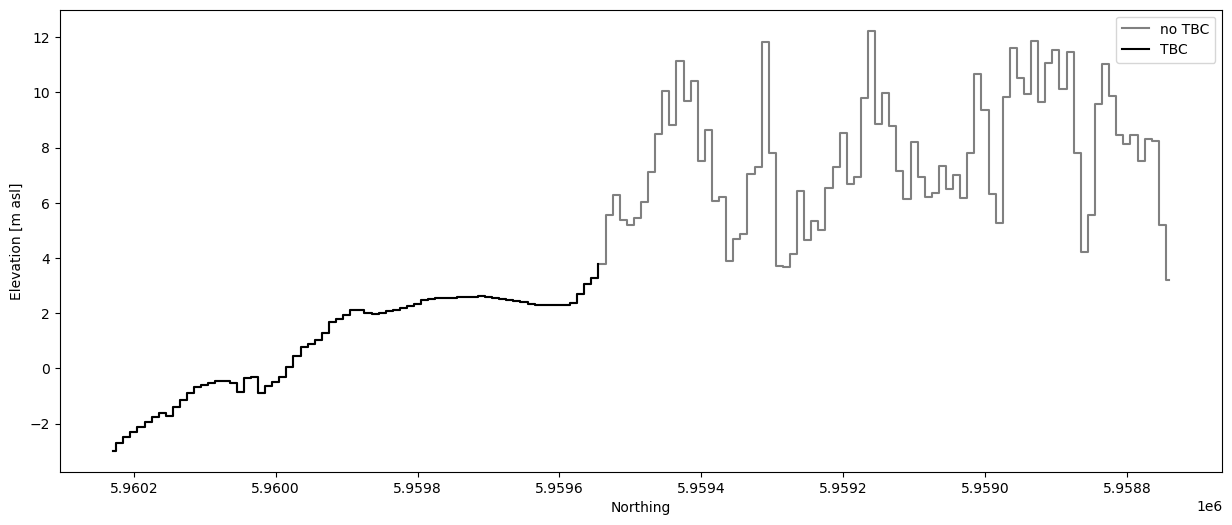

In [9]:
# Visualize slopes and TBC area
# TBC areas
fig, ax = plt.subplots(1, 1, figsize = (15, 6))

ax.step(y_use, top_cs, where = 'mid', color = 'grey', label = 'no TBC')
ax.step(y_allow, top_allow, where = 'mid', color = 'k', label = 'TBC')

ax.set_xlabel('Northing')
ax.set_ylabel('Elevation [m asl]')
ax.invert_xaxis()

ax.legend()

There is an option to write the input files for GHB and DRN using a Fortran based approach which is faster than the flopy internal file write. This is especially handy for models with many cells that hold a PA-TBC and a lot of stress periods.

In [10]:
do_write_fort = True

# Set up PA-TBC object, loop through stress periods
spd_ghb = {}
spd_drn = {}
zep = []

for k, (mtl, amp, period) in enumerate(zip(hs, A, T)):
    # Create PA-TBC object for current stress period
    patbc = mfpatbc.PATBC(swt, mtl, amp, period, hk, vka, sy, z_D, slope_use, 
                          allow = allow_cs, rho_fresh = 1000, rho_salt = 1025,
                          set_ghbdens = 1025)

    # Get stress period entries for GHB input file
    spd_ghb[k] = patbc.get_ghb_stress_period_data()
    
    # Get stress period entries for DRN input file
    spd_drn[k] = patbc.get_drn_stress_period_data()
    
# Check if surface elevation is set according to DEM in patbc
print(np.sum(patbc.z != top_cs) == 0)

# Definition of GHB and DRN stress period data and flopy packages for Fortran based input file writing
if do_write_fort:
    # Only write dummy flopy objects, so that packages are written to nam-file
    ghb = flopy.modflow.ModflowGhb(swt, stress_period_data = {0: [0, 0, 0, 0, 0]})
    drn = flopy.modflow.ModflowDrn(swt, stress_period_data = {0: [0, 0, 0, 0, 0]})

else:
    # Using NOPRINT option to omit printing boundary condition information to list file
    ghb = flopy.modflow.ModflowGhb(
        swt,
        stress_period_data = spd_ghb,
        options = ['NOPRINT', 'IGHBELEV', 'IGHBDENS'],
        dtype = spd_ghb[0].dtype
    )

    drn = flopy.modflow.ModflowDrn(
        swt,
        stress_period_data = spd_drn,
        options = ['NOPRINT', 'IDRNELEV'],
        dtype = spd_drn[0].dtype
    )

True


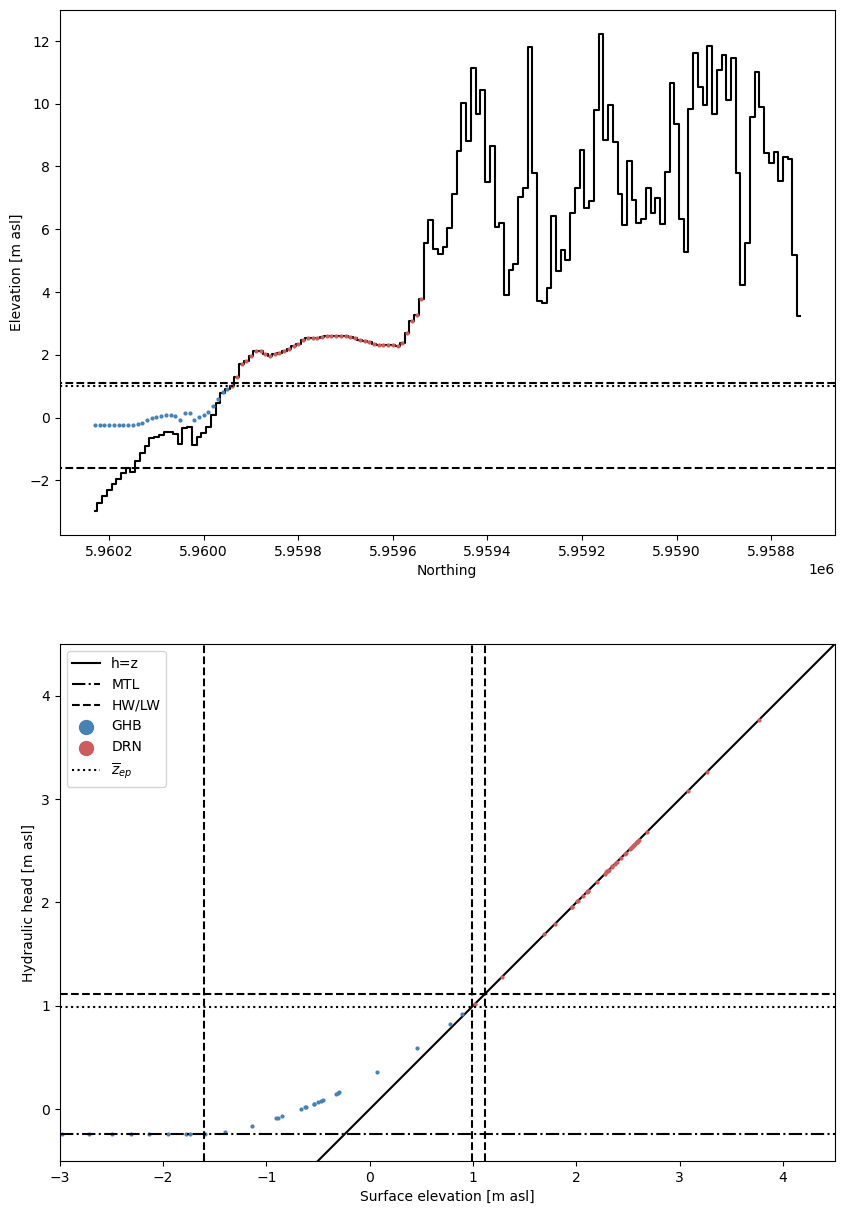

In [11]:
# Visualize example PA-TBC
fig = plt.figure(10, figsize = (10, 15))
kper = nper-1

ghbdata = np.array(spd_ghb[kper].tolist())
drndata = np.array(spd_drn[kper].tolist())

# GHB
col_ghb = ghbdata[::, 2].astype(int)
is_colghb = col_ghb == 0
col_ghb = col_ghb[is_colghb]
row_ghb = ghbdata[::, 1].astype(int)[is_colghb]
h_ghb = ghbdata[::, 3][is_colghb]
z_ghb = patbc.z[row_ghb, col_ghb]

# DRN
col_drn = drndata[::, 2].astype(int)
is_coldrn = col_drn == 0
col_drn = col_drn[is_coldrn]
row_drn = drndata[::, 1].astype(int)[is_coldrn]
h_drn = drndata[::, 3][is_coldrn]
z_drn = patbc.z[row_drn, col_drn]

# Predicted zep
if cma == 'CONSTBS':
    # For plotting purpose only
    lm = pd.read_csv('../../mfpatbc/coef_lm_sim-slopesteady_nwt.csv')
    zep = mfpatbc.predict_zep(hs[kper], A[kper], T[kper], hk, sy, hs[kper]-z_D, vka, slope_use, lm)

# Location of PA-TBC types
ax = fig.add_subplot(211)
ax.step(y_use, top_cs, where = 'mid', color = 'k', zorder = 0)
ax.scatter(y_use[row_ghb], h_ghb, s = 4, c = 'steelblue', label = 'GHB')
ax.scatter(y_use[row_drn], h_drn, s = 4, c = 'indianred', label = 'GHB')

xlim = ax.get_xlim()
ax.hlines([hwlw.LW.values[kper-1], zep, hwlw.HW.values[kper-1]],
         xmin = xlim[0], xmax = xlim[1], 
         colors = 'k', linestyles = ['--', ':', '--'])
ax.set_xlim(xlim)

ax.set_xlabel('Northing')
ax.set_ylabel('Elevation [m asl]')

ax.invert_xaxis()


# PA-TBC hydraulic heads
ax = fig.add_subplot(212)
ax.plot([-3, 4.5], [-3, 4.5], 'k', zorder = 0, label = 'h=z')

ax.hlines([hs[kper], hwlw.HW.values[kper-1]], xmin = -3, xmax = 4.5, linestyles = ['-.', '--'],
        colors = 'k', label = 'MTL')
ax.vlines([hwlw.LW_Mean.values[kper-1], zep, hwlw.HW.values[kper-1]], 
         ymin = -0.5, ymax = 4.5, linestyles = '--', colors = 'k',
         label = 'HW/LW')

ax.scatter(z_ghb, h_ghb, s = 4, c = 'steelblue', label = 'GHB')

ax.scatter(z_drn, h_drn, s = 4, c = 'indianred', label = 'DRN')

ax.hlines(zep, xmin = -3, xmax = 4.5, linestyles = ':', colors = 'k', label = '$\\overline{z}_{ep}$')

ax.set_xlim(-3, 4.5)
ax.set_ylim(-0.5, 4.5)

ax.set_xlabel('Surface elevation [m asl]')
ax.set_ylabel('Hydraulic head [m asl]')

ax.set_aspect('equal')

ax.legend(markerscale = 5)

Exemplary result of the PA-TBC for stress period 1467. GHB is used for all cells where $z > \overline{z}_{ep}$. The phase-averaged groundwater table exit point $\overline{z}_{ep}$ is predicted by the empirical correction function of the PA-TBC. For $z \leq \overline{z}_{ep}$, DRN is used.

GHB uses freshwater heads. Thus, boundary heads deviate from mean tide level with decreasing surface elevation below the low water line.

### Transport model

For transport model, only source and sink mixing package (SSM) needs to be set with information from the PA-TBC. Initial concentrations are set to 0 kg/m³ above the mean high water line and to 35 kg/m³ below to reach a quasi steady-state in the first stress period in a reasonable time frame.

The SSM entries for the GHB can be set using patbc.get_ssm_stress_period_data().
So far it is only implemented to set SSM cells to all cells at the aquifer-ocean interface that are generelly allowed to hold a PA-TBC (allow_cs). Thus, SSM cells are defined only for the first stress period.

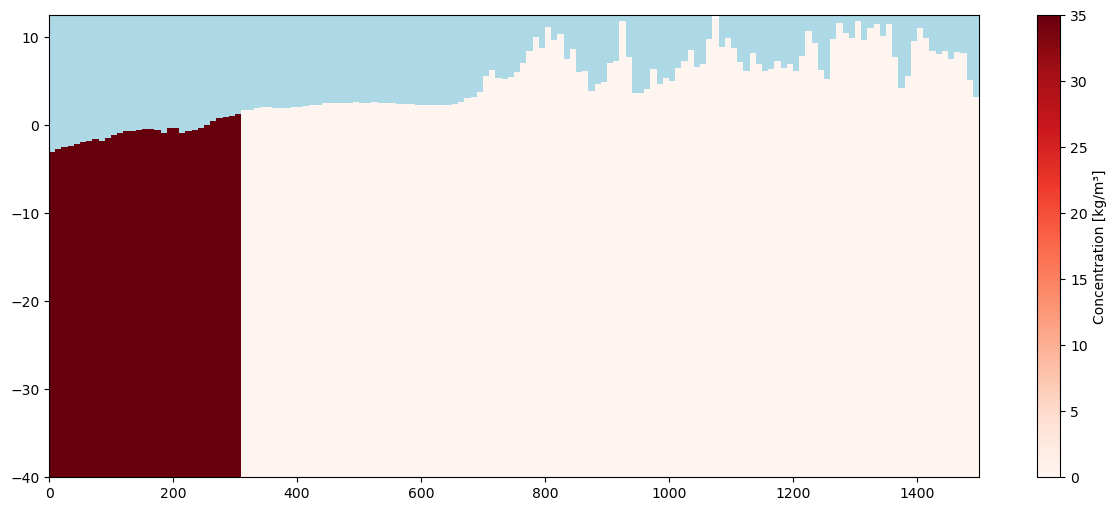

In [12]:
# Basic transport package
sconc = np.zeros((nlay, nrow, ncol))
use_salt = hwlw.HW.values.mean() > top_cs
for k in range(nlay):
    sconc[k][use_salt] = 35

btn = flopy.mt3d.Mt3dBtn(
    swt,
    nprs = 0,
    prsity = sy,
    sconc = sconc,
    dt0 = 0,
    tunit = 'D',
    lunit = 'M'
)


# Advection, MOC
adv = flopy.mt3d.Mt3dAdv(
    swt,
    mixelm = 1,
    percel = 0.75,
    mxpart = 1e7,
    itrack = 1,
    wd = 0.8,
    nplane = 0,
    npl = 0,
    nph = 32,
    npmin = 2,
    npmax = 64
)


# Dispersion
dsp = flopy.mt3d.Mt3dDsp(
    swt,
    al = 1,
    trpt = 0.1,
    trpv = 0.01,
    dmcoef = 0
)


# Source and sink mixing
# Get cells that represent aquifer-ocean interface and are allowed to hold a PA-TBC.
spd_ssmghb = patbc.get_ssm_stress_period_data(conc_ghb = 35)
ssm = flopy.mt3d.Mt3dSsm(
    swt,
    crch = 0,
    stress_period_data = spd_ssmghb,
    mxss = 1000
)

# Transport solver
gcg = flopy.mt3d.Mt3dGcg(
    swt,
    iter1 = 500,
    mxiter = 1,
    isolve = 1,
    ncrs = 1,
    cclose = 1e-6
)


# Variable density
vdf = flopy.seawat.SeawatVdf(
    swt,
    mtdnconc = 1, # couple flow and transport
    nswtcpl = 0,
    iwtable = 1,
    densemin = 1000,
    densemax = 1025,
    denseref = 1000, 
    drhodc = 0.7143, # rho_salt = 1025 kg/m³ and conc_salt = 35 kg/m³
    firstdt = 1e-6
)

# Inital concentrations
fig, ax = plt.subplots(1, 1, num = 0, figsize = (15, 6))
p = flopy.plot.PlotCrossSection(swt, modelgrid = swt.modelgrid, line = {'column': 0}, ax = ax)
im = p.plot_array(btn.sconc[0].array, cmap = 'Reds')
cbar = fig.colorbar(im, ax = ax)
cbar.set_label('Concentration [kg/m³]')
p.plot_ibound(color_noflow = 'lightblue')

### Write input files and run simulation

GHB and DRN input files are written separately because flopy does not support SEAWAT auxiliar variables IGHBELEV and IDRNELEV.

In [13]:
# Delete files in model workspace, since MT3DMS output binary files are not reset when simulation is re-run.
filenames = glob.glob(model_ws + '/*')
for f in filenames:
    try:
        os.remove(f)
    except:
        print(f + ' could not be removed.')

if do_write_fort:
    packages = swt.get_package_list()
    packages = [name for name in packages if (name != 'GHB') & (name != 'DRN')]
    
    swt.write_input(SelPackList = packages)
    
    mfpatbc.write_ghb(swt, spd_ghb, options = ['NOPRINT', 'IGHBELEV', 'IGHBDENS'])
    mfpatbc.write_drn(swt, spd_drn, options = ['NOPRINT', 'IDRNELEV'])        

else:
    swt.write_input()

In [14]:
success, buff = swt.run_model(silent=True)
if not success:
    raise Exception("SEAWAT did not terminate normally.")

### Visualize simulation results

It can be seen that the PA-TBC propagates the transient ocena dynamics with periods londer than semi-diurnal into the aquifer. Tidal overheight is produced and the ocean signal variability is attenuated with distance to coast. Well within the dune area only storm flood events have a direct impact.

In [15]:
hdobj = flopy.utils.HeadFile(f'{model_ws}/{modelname}.hds')
cobj = flopy.utils.UcnFile(f"{model_ws}/MT3D001.UCN")

In [16]:
timestep, stressperiod = np.array(hdobj.get_kstpkper()).T
gw_table = []
concentration = []
ndry = []
hghb_max = []
hdry = -100
zf = swt.modelgrid.zcellcenters

for k, idx in enumerate(zip(timestep, stressperiod)):
    concentration.append(cobj.get_data(kstpkper = idx))
    is_dry = concentration[k] >= 1e10
    concentration[k][is_dry] = np.nan
    concentration[k][ibound == 0] = np.nan
    rho = 1000 + concentration[k]*0.7143
    
    hds_fresh = hdobj.get_data(kstpkper = idx)
    hds_fresh[ibound == 0] = -999 # Some inactive cells got head values set them to inactive
    hds = 1000/rho * hds_fresh + (rho-1000)/rho * zf
    
    # Find heads that are dry but not no-flow
    is_really_dry = hds_fresh < -1e10
    # Get number of dry cell layers in each model row
    ndry.append(is_really_dry.sum(axis = 0))
    
    # Get maximum head of PA-TBC GHB cells
    ghbdata = np.array(spd_ghb[idx[1]].tolist())
    hghb = ghbdata[::, 3]
    hghb_max.append(hghb.max())
    
    is_dry = (hds < hdry) | np.isnan(hds)
    hds[is_dry] = hdry

    gw_table.append(flopy.utils.postprocessing.get_water_table(hds, hdry))
    
gw_table = np.array(gw_table)
concentration = np.array(concentration)
ndry = np.array(ndry).squeeze()
hghb_max = np.array(hghb_max)

False

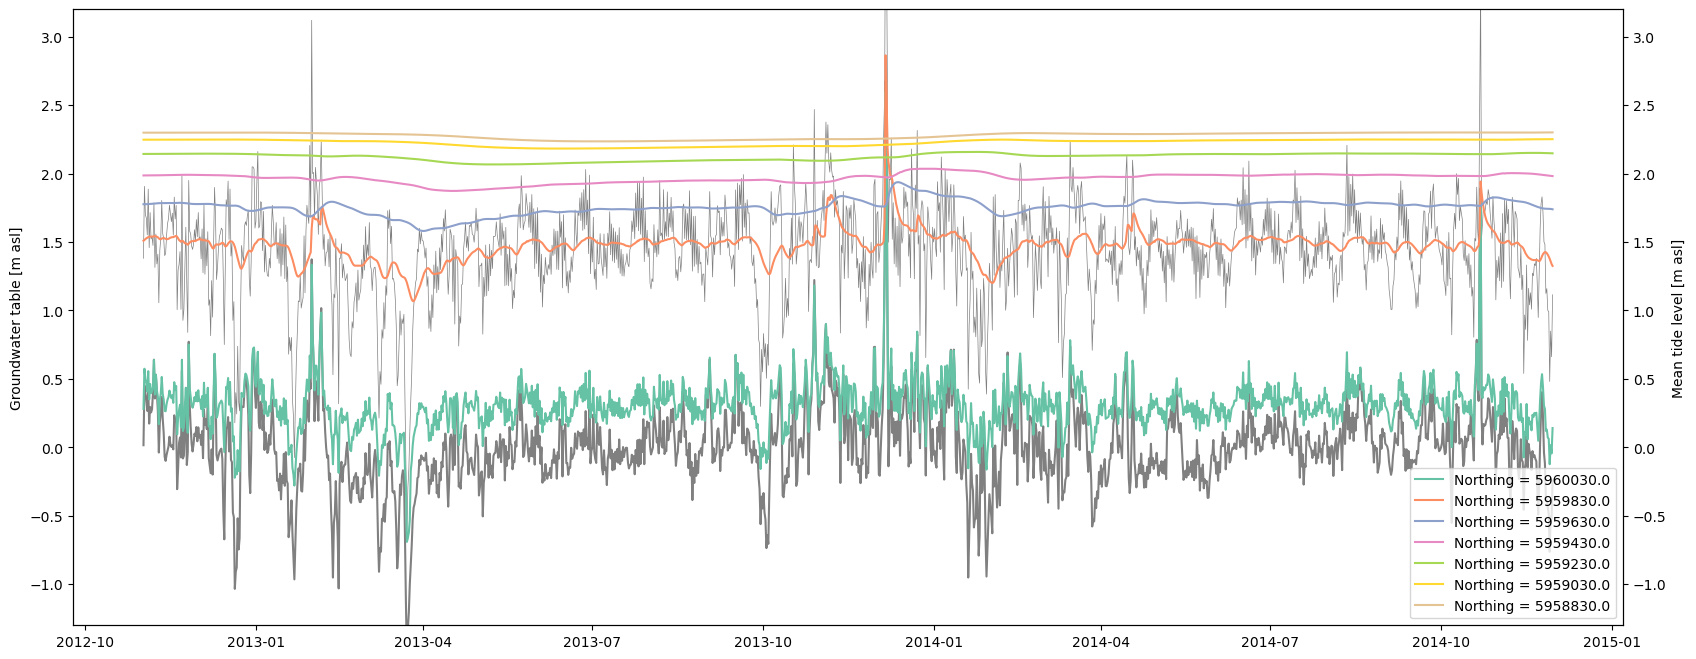

In [17]:
clrs = cm.Set2(np.arange(0, row_plt.size))

fig, ax = plt.subplots(1, 1, num = 20, figsize = (20, 8))
for k, row in enumerate(row_plt):
    ax.plot(hwlw.DateTime_Mean.values[:(gw_table.shape[0]-1)], gw_table[1::, row], color = clrs[k], label = f'Northing = {y[row]}')
ax.set_ylim(-1.3, 3.2)
ax.set_ylabel('Groundwater table [m asl]')
ax.set_zorder(10)
ax.patch.set_visible(False)
ax.legend()

axt = ax.twinx()
axt.plot(hwlw.DateTime_Mean.values, hwlw.SL_HWLW.values, color = 'grey', label = 'MTL')
axt.plot(hwlw.DateTime_Mean.values, hwlw.HW.values, color = 'grey', label = 'MTL', linestyle = '-', 
         linewidth = 0.5)
axt.set_ylim(-1.3, 3.2)
axt.set_ylabel('Mean tide level [m asl]')
any(hds.reshape(-1) < -100)

Text(0, 0.5, 'Total mass [kg]')

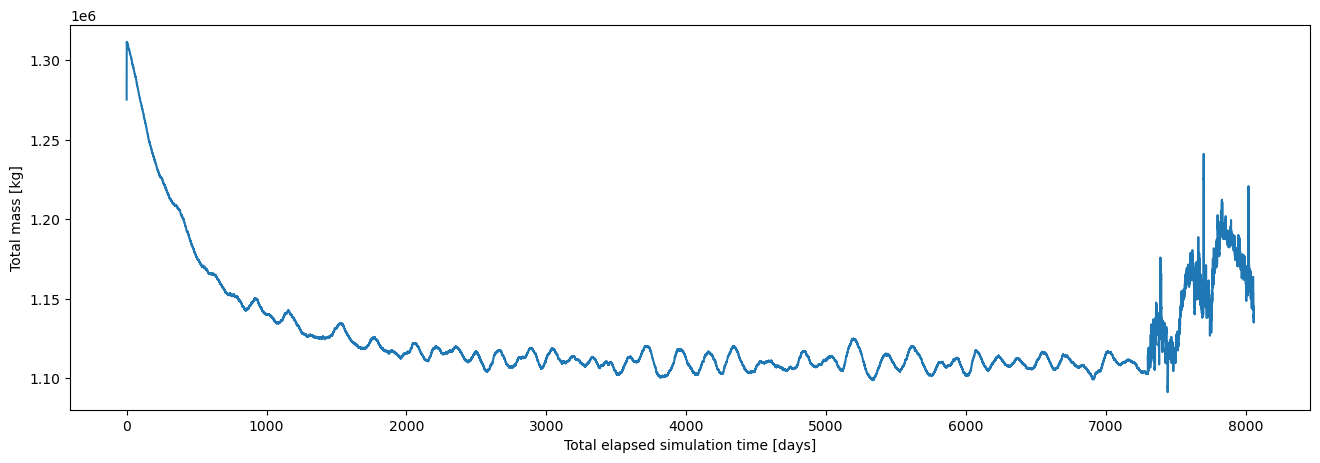

In [18]:
masobj = pd.DataFrame.from_records(flopy.mt3d.Mt3dms.load_mas(f"{model_ws}/MT3D001.MAS"))
tmas = masobj.time.values
totmas = masobj.total_mass.values

fig, ax = plt.subplots(1, 1, num = 21, figsize = (16, 5))
ax.plot(tmas, totmas)
ax.set_xlabel('Total elapsed simulation time [days]')
ax.set_ylabel('Total mass [kg]')

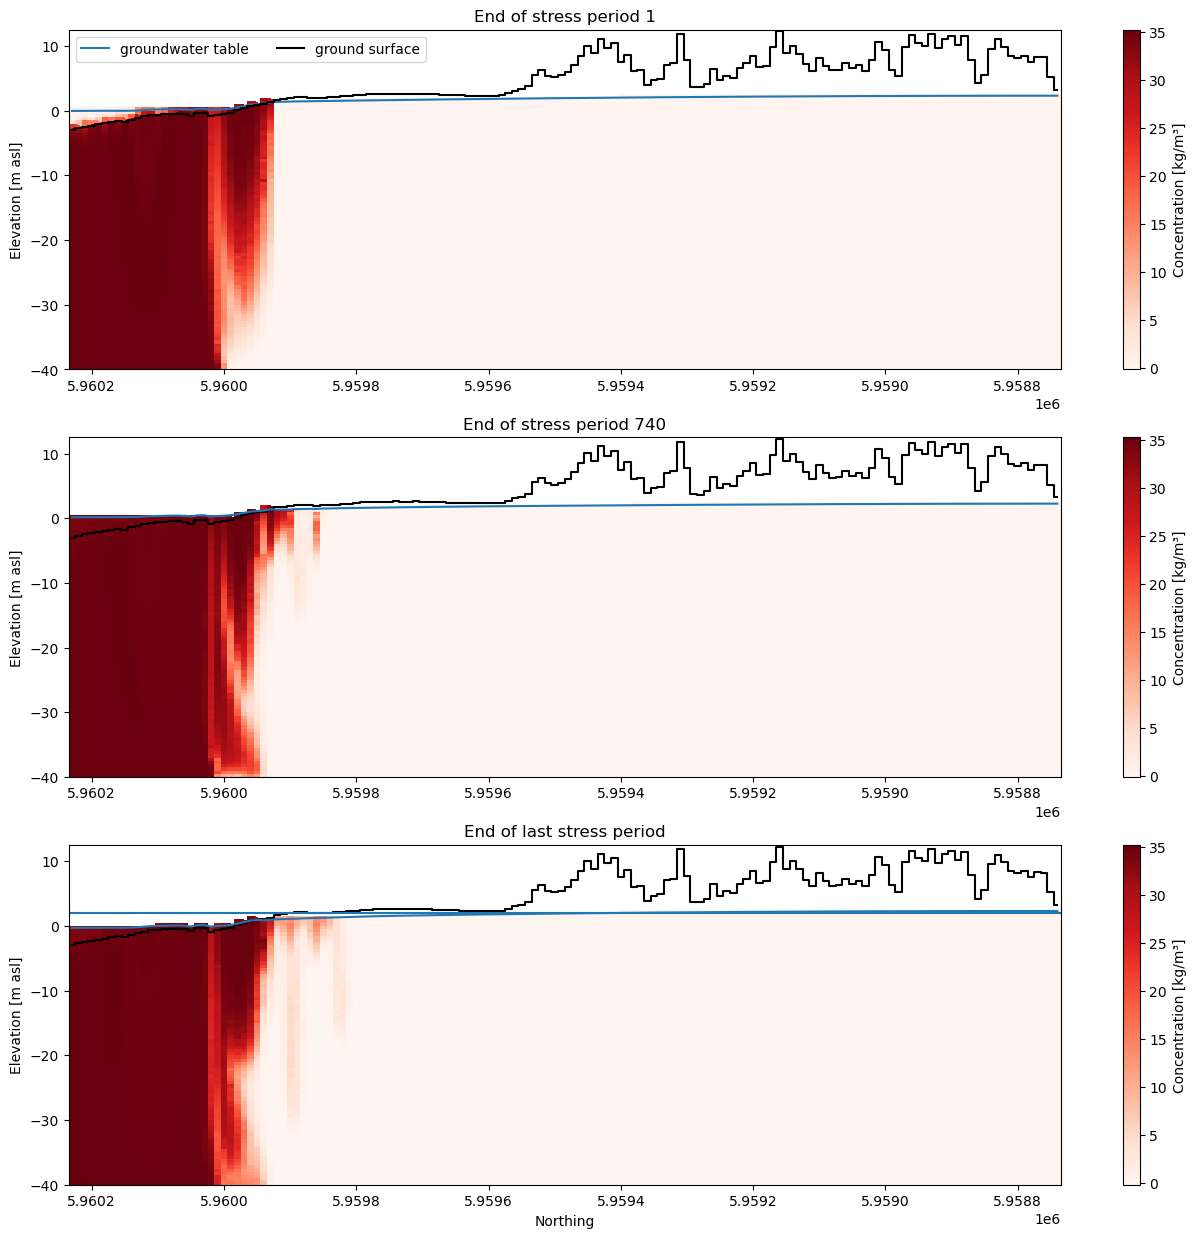

In [19]:
# Concentrations after first quasi-steady state stress period
concentration_first = cobj.get_data(kstpkper = (timestep[0], stressperiod[0])).squeeze()
concentration_first[concentration_first >= 1e10] = np.nan

concentration = []
concentration.append(cobj.get_data(kstpkper = (timestep[740], stressperiod[740])).squeeze())
concentration.append(cobj.get_data(kstpkper = (timestep[1467], stressperiod[1467])).squeeze())
concentration = np.array(concentration)
concentration[concentration >= 1e10] = np.nan

Y = np.repeat(swt.modelgrid.yvertices[::, 0].reshape(-1, 1), nlay+1, axis = 1).T#.reshape(nlay+1, nrow+1)
Z = np.concatenate([swt.modelgrid.zvertices.squeeze(), 
                    swt.modelgrid.zvertices.squeeze()[::, -1].reshape(-1, 1)], axis = 1)


fig, (axa, axb, axc) = plt.subplots(3, 1, num = 21, figsize = (16, 15))

# Quasi-steady state
im = axa.pcolormesh(Y, Z, concentration_first, cmap = 'Reds')
cbar = fig.colorbar(im, ax = axa)
cbar.set_label('Concentration [kg/m³]')
axa.plot(y_use, gw_table[0], label = 'groundwater table')
axa.step(y_use, top_cs, where = 'mid', color = 'k', label = 'ground surface')
axa.set_title('End of stress period 1')
axa.set_ylabel('Elevation [m asl]')
axa.invert_xaxis()
axa.legend(loc = 'upper left', ncol = 2)

# per 740
axb.pcolormesh(Y, Z, concentration[0], cmap = 'Reds')
cbar = fig.colorbar(im, ax = axb)
cbar.set_label('Concentration [kg/m³]')
axb.step(y_use, top_cs, where = 'mid', color = 'k')
axb.plot(y_use, gw_table[740])
axb.set_title('End of stress period 740')
axb.set_ylabel('Elevation [m asl]')
axb.invert_xaxis()

# Last per
axc.pcolormesh(Y, Z, concentration[1], cmap = 'Reds')
cbar = fig.colorbar(im, ax = axc)
cbar.set_label('Concentration [kg/m³]')
axc.step(y_use, top_cs, where = 'mid', color = 'k')
axc.plot(y_use, gw_table[1467])
axc.set_title('End of last stress period')
axc.set_xlabel('Northing')
axc.set_ylabel('Elevation [m asl]')
axc.invert_xaxis()
axc.hlines(2, xmin = axc.get_xlim()[0], xmax = axc.get_xlim()[1])